In [1]:
%matplotlib inline
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
LW=5 # linewidth
MS=10 # markersize
from scipy import stats


In [2]:
def pendulum_dyn(current_state, dt=0.1):
    """Pendulum dynamics
    
    Inputs
    ------
    Current_state : either (2,) or (N, 2) for vectorized input
    """
    if current_state.ndim == 1:
        next_state = np.zeros((2))
        next_state[0] = current_state[0] + dt * current_state[1]
        next_state[1] = current_state[1] - dt * 9.81 * np.sin(current_state[0])
    else: # multiple inputs
        next_state = np.zeros(current_state.shape)
        next_state[:, 0] = current_state[:, 0] + dt * current_state[:, 1]
        next_state[:, 1] = current_state[:, 1] - dt * 9.81 * np.sin(current_state[:, 0])
    return next_state

def observe(current_state):
    if current_state.ndim == 1:
        out = np.zeros((1))
        out[0] = np.sin(current_state[0])
    else:
        out = np.zeros((current_state.shape[0], 1))
        out[:, 0] = np.sin(current_state[:, 0])
    return out

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
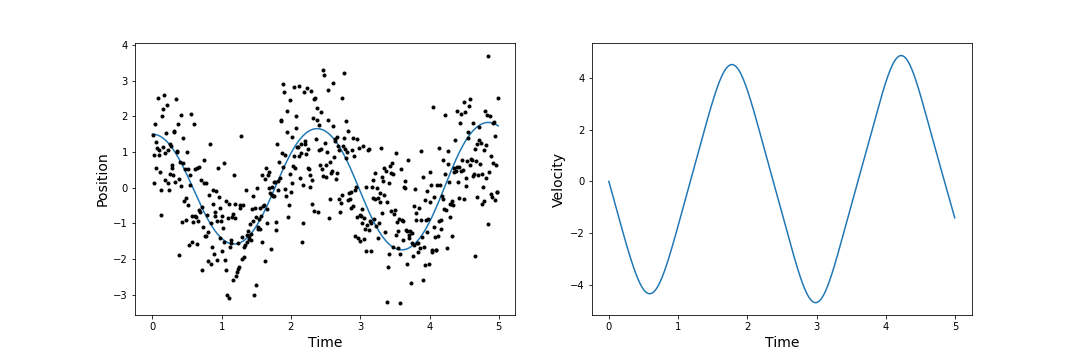

In [3]:
x0 = np.array([1.5, 0])
dt = 0.01
Nsteps = 500
true = np.zeros((Nsteps, 2))
true[0, :] = x0
times = np.arange(0, Nsteps*dt, dt)
data = np.zeros((Nsteps-1, 1))
ns = 1.0 # standard deviation of noise
noise_var = ns*ns
for ii in range(1, Nsteps):
    true[ii, :] = pendulum_dyn(true[ii-1, :],dt=dt)
    data[ii-1] = observe(true[ii, :]) + np.random.randn()*ns

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(times, true[:, 0])
axs[0].plot(times[1:], data, 'ko', ms=3)
axs[0].set_xlabel("Time", fontsize=14)
axs[0].set_ylabel("Position", fontsize=14)
axs[1].plot(times, true[:, 1])
axs[1].set_xlabel("Time", fontsize=14)
axs[1].set_ylabel("Velocity", fontsize=14)
plt.show()

In [4]:
def resample(Nsamples, samples, weights):
    """Generate *Nsamples* samples from an empirical distribution defined by *samples* and *weights*
    
    Inputs
    ------
    Nsamples: integer, number of samples to generate
    samples: (N, d) array of N samples of dimension d that form the empirical distribution
    weights: (N, ) array of N weights
    
    Returns
    --------
    samples_out: (Nsamples, d) new samples
    weights_out: (Nsamples, ) new weights equal to 1 / N
    """

    N = samples.shape[0]  # get number of points that make up the empirical distribution
    rr = np.arange(N) # get an ordered set of numbers from 0 to N-1
    
    # Randomly choose the integers (with replacement) between 0 to N-1 with probabilities given by the weights
    samp_inds = np.random.choice(rr, Nsamples, p=weights) 

    # subselect the samples chosen
    samples_out = samples[samp_inds, :]
    
    # return uniform weights
    weights_out = np.ones((Nsamples))/Nsamples
    return samples_out, weights_out

In [5]:
def compute_mean_std(samples, weights):
    """Compute the mean and standard deviation of multiple empirical distirbution
    
    Inputs
    ------
    samples: (N, d, m) array of samples defining the empirical distribution
    weights: (N, m) array of weights
    
    Returns
    -------
    means: (m, d) array of means
    stds: (m, d) array of standard deviations
    
    Notes
    -----
    m is the number of empirical distributions
    """
    
    N, d, m = samples.shape
    means = np.zeros((m, d))
    stds = np.zeros((m, d))
    for ii in range(m):
        means[ii, :] = np.dot(weights[:, ii], samples[:, :, ii])
        stds[ii, :] = np.sqrt(np.dot(weights[:, ii], (samples[:, :, ii] - np.tile(means[ii, :], (N, 1)))**2))
    return means, stds

In [6]:
def step(prop, proppdf, current_samples, current_weights, likelihood, data, propagator, R):
    """
    Propagate a particle filter
    
    @param[in] prop            - proposal function (current_state, data)
    @param[in] proppdf         - proposal function logpdf
    @param[in] current_samples - ensemble of samples
    @param[in] current_weights - ensemble of weights
    @param[in] likelihood      - function to evaluate the log likelihood (samples, data)
    @param[in] data            - Observation
    @param[in] propagator      - dynamics logpdf
    
    @returns samples and weights after assimilating the data
    """
    #new_samples = np.zeros(current_samples.shape)
    #new_weights = np.zeros(current_weights.shape)
    
    new_samples = prop(current_samples, data)
    new_weights = likelihood(new_samples, data, R) + propagator(new_samples, current_samples) - \
                            proppdf(new_samples, current_samples, data)
    new_weights = np.exp(new_weights) * current_weights
    #for ii in range(new_samples.shape[0]):
    #    new_samples[ii, :] = prop(current_samples[ii, :], data)
    #    new_weights[ii] = np.exp(likelihood(new_samples[ii, :], data) + 
    #                                propagator(new_samples[ii, :], current_samples[ii, :]) -
    #                                proppdf(new_samples[ii, :], current_samples[ii, :], data))      
    #    new_weights[ii] *= current_weights[ii]
        
    # normalize weights
    new_weights = new_weights / np.sum(new_weights)
    return new_samples, new_weights

In [7]:
def particle_filter(data, prior_mean, prior_cov,                     
                    prop, proppdf, likelihood, propagator, delta,R,
                    nsamples=1000, resampling_threshold_frac=0.1):
    """Particle Filter
      
    Inputs
    -------
    data: (nsteps, m) array of data points, N is the time index, m is the dimensionality of the data
    prior_mean: (d), prior mean
    prior_cov: (d, d), prior mean
    Nsamples: integer, number of samples in the empirical distribution
    resampling_threshold_frac: float between 0 and 1 indicating to resample when effective sample size below frac of nsamples

    Returns
    -------
    samples: (nsamples, d, nsteps)
    weights: (nsamples, nsteps)
    eff: (nsamples), effective sample size
    
    Notes
    -----
    For documentation of prop, proppdf, likelihood, and propagator -- see the step function
    """
    
    d = prior_mean.shape[0] 
    nsteps = data.shape[0]

    # Allocate memory
    samples = np.zeros((nsamples, d, nsteps+1))
    weights = np.zeros((nsamples, nsteps+1))
    eff = np.zeros((nsteps+1)) # keep track of effective sample size at each step
    
    
    # Generate initial samples from the prior
    L = np.linalg.cholesky(prior_cov)
    samples[:, :, 0] = np.tile(prior_mean, (nsamples, 1))+ np.dot(L, np.random.randn(d, nsamples)).T
    weights[:, 0] = 1.0 / nsamples # all weights are equal because of independent sampling from prior
    eff[0] = nsamples

    resamp_threshold = int(nsamples * resampling_threshold_frac)

    for ii in range(1, nsteps+1):
        if ii%delta==1:
            samples[:, :, ii], weights[:, ii] = step(prop,  proppdf, samples[:, :, ii-1], weights[:, ii-1],
                                                 likelihood, data[ii-1,:], propagator,R)
        else:
            samples[:,:,ii] = prop(samples[:, :, ii-1], data[ii-1,:])
            weights[:,ii]=weights[:,ii-1]
            
        # compute the effective sample size
        eff[ii] = 1.0 / np.sum(weights[:, ii]**2)
        
        #if ii % 50 == 0:
            #print("eff = ", ii, eff[ii])
        #print("eff/emean = ", eff[ii], means[ii, :])
        
        # resample if effective sample size is below threshold
        if eff[ii] < resamp_threshold:
            samples[:, :, ii], weights[:, ii] = resample(nsamples, samples[:, :, ii], weights[:, ii])


    return samples, weights, eff

In [8]:
# Process noise
proc_var=0.5
proc_mat = np.zeros((2,2))
proc_mat[0, 0] = proc_var/3.0*dt**3
proc_mat[0, 1] = proc_var/2.0*dt**2
proc_mat[1, 0] = proc_var/2.0*dt**2
proc_mat[1, 1] = proc_var*dt
proc_mat_inv = np.linalg.pinv(proc_mat)
Lproc  = np.linalg.cholesky(proc_mat)

def proposal(current_state, data=None, dt=dt):
    """ Bootstrap Particle Filter the proposal is the dynamics!"""
    
    if current_state.ndim == 1:
        return pendulum_dyn(current_state, dt=dt) + np.dot(Lproc, np.random.randn(2))
    else:
        nsamples = current_state.shape[0]
        return pendulum_dyn(current_state, dt=dt) + np.dot(Lproc, np.random.randn(2, nsamples)).T

def proposal_logpdf(current, previous, data=None, proc_var=0.1):
    """ Bootstrap Particle Filter: the proposal is the dynamics"""
    nexts  = pendulum_dyn(previous, dt=dt)
    delta = nexts - current
    if current.ndim == 1:
        return -0.5 * np.dot(delta, np.dot(proc_mat_inv, delta))
    else:
        return -0.5 * np.sum(delta * np.dot(delta, proc_mat_inv.T), axis=1)

def likelihood(state, data, noise_var):
    """Gaussian Likelihood through nonlinear model"""
    dpropose = observe(state)
    delta = dpropose - data
    if state.ndim == 1:
        return -0.5 * np.dot(delta, delta) / noise_var
    else:
        return -0.5 * np.sum(delta * delta, axis=1) / noise_var 

In [9]:
prior_mean = true[0, :] # start at the truth -- this is obviously not possible in reality
prior_cov = np.eye(2) # identity covariance
delta = 5
R = 1
samples, weights, eff =  particle_filter(data, prior_mean, prior_cov,              
                                            proposal, proposal_logpdf, likelihood, proposal_logpdf,
                                            delta, R,nsamples=1000, resampling_threshold_frac=0.1,)
weights.shape

(1000, 500)

In [10]:
def UKF_prediction_step(mean, cov, sigma, alpha=1, beta=0, kappa=0):
    
    dimPre = cov.shape[0]
    UP, w = unscented_points(mean, cov, alg='chol') # returns: pts, (W0m, Wim, W0C, Wic)

    # Mean

    u0 = np.reshape(UP[0,:], (dimPre,1))
    dynamicsOutMean0 = nonlinphi(u0.T)*w[0]
    dynamicsOutMean0 = np.reshape(dynamicsOutMean0, (1, dimPre))
    dynamicsOutMean  = dynamicsOutMean0

    for jj in range(1,UP.shape[0]):
        ui = np.reshape(UP[jj,:], (dimPre,1))
        dynamicsOutMeani = nonlinphi(ui.T)*w[1]
        dynamicsOutMean = dynamicsOutMean + dynamicsOutMeani
    
    pred_mean = dynamicsOutMean

    # Cov

    dynamicsOutCov0 = np.dot((nonlinphi(u0.T)- pred_mean).T,\
                             ((nonlinphi(u0.T)- pred_mean).T).T)*w[2]
    dynamicsOutCov  = dynamicsOutCov0
    
    for jj in range(1,UP.shape[0]):
        ui = np.reshape(UP[jj,:], (dimPre,1))
        dynamicsOutCovi = np.dot((nonlinphi(ui.T)- pred_mean).T,\
                                ((nonlinphi(ui.T)- pred_mean).T).T)*w[3] 

        dynamicsOutCov  = dynamicsOutCov + dynamicsOutCovi   
                                   
    pred_cov = dynamicsOutCov + sigma

    return pred_mean, pred_cov

In [11]:
def UKF_update_step(data, mean, cov, gamma, alpha=1, beta=0, kappa=0):
    
    dimPre = cov.shape[0]
    
    UP, w = unscented_points(mean, cov, alg='chol') # returns pts, (W0m, Wim, W0C, Wic)

    # Mean
    u0 = np.reshape(UP[0,:], (dimPre,1))
    dynamicsOutMean0 = nonlinh(u0.T)*w[0]
    dynamicsOutMean  = dynamicsOutMean0
    
    for jj in range(1,UP.shape[0]):
        ui = np.reshape(UP[jj,:], (dimPre,1))
        dynamicsOutMeani = nonlinh(ui.T)*w[1]
        dynamicsOutMean = dynamicsOutMean + dynamicsOutMeani
    
    mu = dynamicsOutMean
    delta = data - mu
        
    # Cov

    dynamicsOutU0 = np.dot((u0 - mean.T),\
                           (nonlinh(u0.T)- mu).T)*w[2]
    dynamicsOutU  = dynamicsOutU0
    for jj in range(1,UP.shape[0]):
        ui = np.reshape(UP[jj,:], (dimPre,1))
        dynamicsOutUi = np.dot((ui - mean.T),\
                               (nonlinh(ui.T)- mu).T)*w[3] 
        dynamicsOutU  = dynamicsOutU + dynamicsOutUi           
        
        
    dynamicsOutS0 = np.dot((nonlinh(u0.T)- mu),\
                           (nonlinh(u0.T)- mu).T)*w[2]
    dynamicsOutS  = dynamicsOutS0
    for jj in range(1,UP.shape[0]):
        ui = np.reshape(UP[jj,:], (dimPre,1))
        dynamicsOutSi = np.dot((nonlinh(ui.T)- mu),\
                               (nonlinh(ui.T)- mu).T)*w[3] 
        dynamicsOutS  = dynamicsOutS + dynamicsOutSi   
                                   
    S = dynamicsOutS + gamma
    U = dynamicsOutU
    USinv = U/S
    
    update_mean = mean + (np.dot(USinv,delta)).T
    update_cov  = cov - np.dot(USinv, U.T)
    update_mean = update_mean.squeeze()

    return update_mean, update_cov

In [12]:
def UKF(N,data, proc_cov, meas_cov, prior_mean, prior_cov, delta):

    d = prior_mean.shape[0]
    mean_store = np.zeros((d,N+1))
    mean_store[:,0] = np.copy((prior_mean).squeeze())
    cov_store = np.zeros((d, d, N+1))
    cov_store[:, :, 0] = np.copy(prior_cov)
    
    #Loop over all data
    for ii in range(N):
        mean_ii = mean_store[:,ii]
        
        # Prediction
        pred_mean, pred_cov = UKF_prediction_step(mean_ii, cov_store[:, :, ii], proc_cov, alpha=1, beta=0, kappa=0)
        
        # Update if measurement is available
        if ii%delta == 0:
            mean_store[:,ii+1], cov_store[:, :, ii+1] = UKF_update_step(data[int(ii/delta)],pred_mean, pred_cov, meas_cov, alpha=1, beta=0, kappa=0)
        else:
            mean_store[:,ii+1]   = pred_mean.squeeze()
            cov_store[:, :, ii+1] = pred_cov
        
    return mean_store, cov_store

In [21]:
def plot_2d(weights, samples, xlim, ylim):
    """A function to plot an empirical distribution"""
    Nsamples = 3000
    s, w = resample(Nsamples, samples, weights) # resample to obtain equal weights
    
    xspace = np.linspace(xlim[0], xlim[1],100)
    yspace = np.linspace(ylim[0], ylim[1],100)
    XX, YY = np.meshgrid(xspace, yspace)

    fig, axs = plt.subplots(1,1)

    positions = np.vstack([XX.ravel(), YY.ravel()])
    values = np.vstack([s[:, 0], s[:, 1]])
    kernel = stats.gaussian_kde(values) # kernel density estimate to get contours
    f = np.reshape(kernel(positions).T, XX.shape)
#     axs.contour(XX, YY, f,)
    axs.plot(s[:, 0], s[:, 1], 'x', color='grey', alpha=0.1)
    axs.set_xlabel("angle")
    axs.set_ylabel("angular rate")

    return fig, axs

Text(0.5, 0.98, 'Joint Posteriors')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
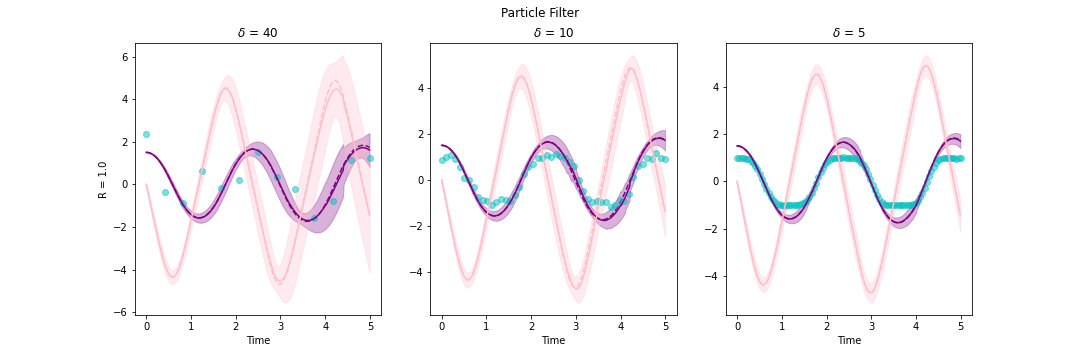

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
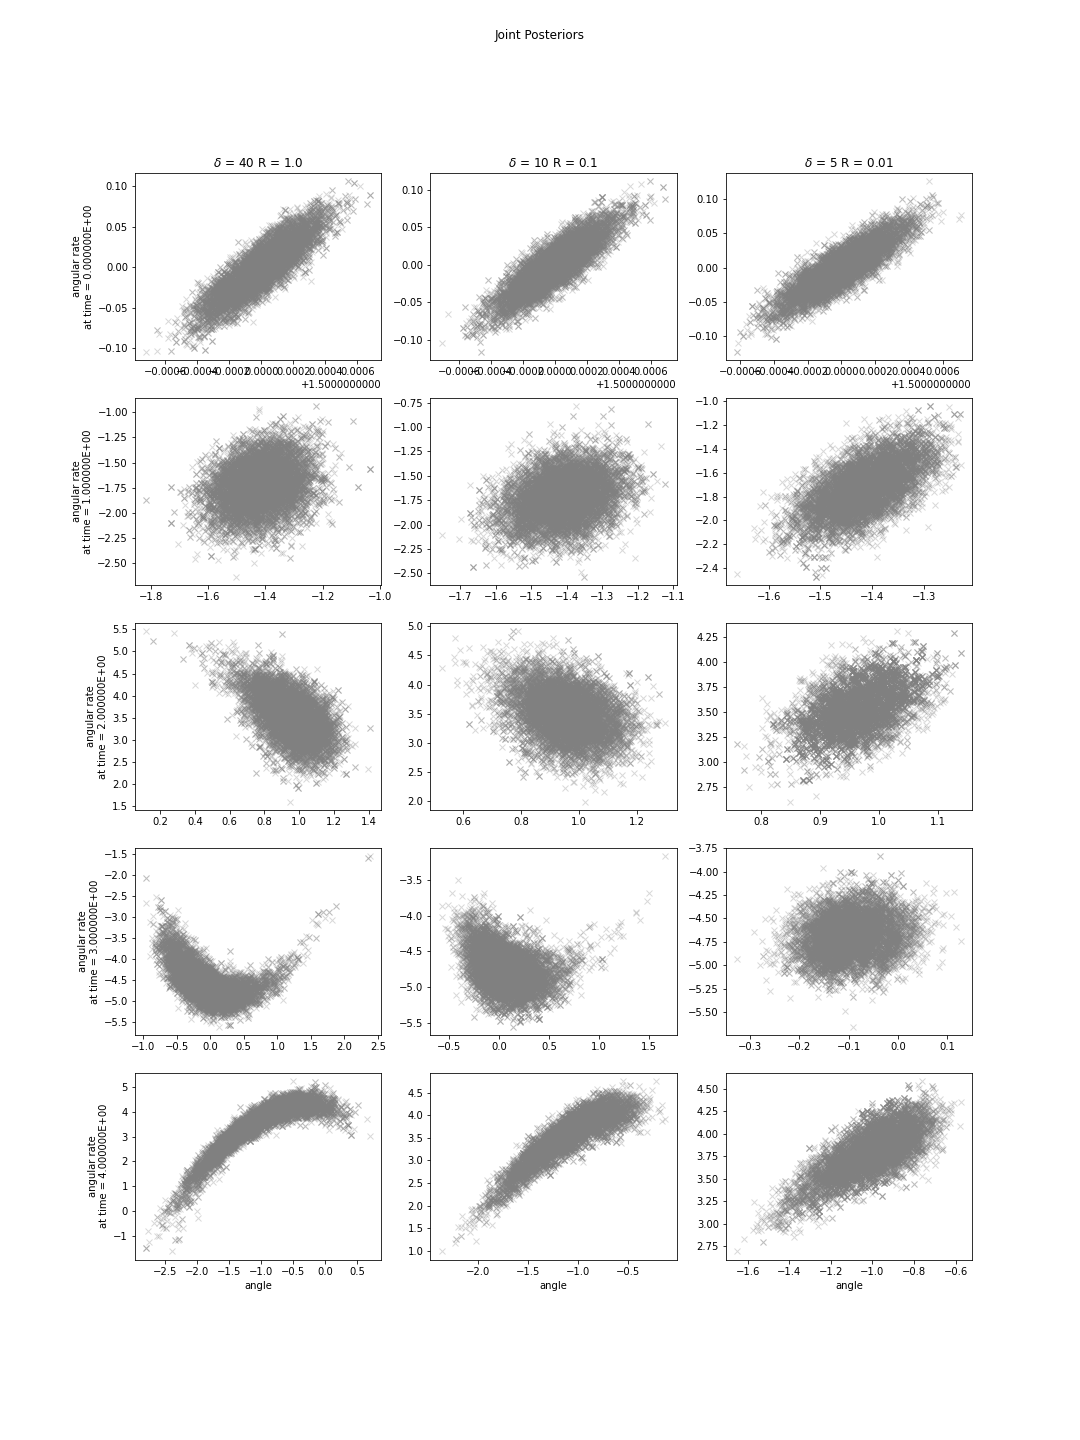

In [74]:
# sadece particle
x0 = np.array([1.5, 0])
Nsteps = 500
N = Nsteps
qc = 0.1
deltat = 0.01
dt = deltat
deltaArray = np.array([40,10,5])
RArray = np.array([1, 0.1, 0.01]) 
Q = np.array([[(qc*deltat**3)/3 , (qc*deltat**2)/2 ],
              [(qc*deltat**2)/2 ,  qc*deltat]])
proc_var = qc


# fig, sp = plt.subplots(1,2,figsize=(15,15))    
# fig2, sp2 = plt.subplots(1,2,figsize=(15,15)) 
# fig3, sp3 = plt.subplots(1,2,figsize=(15,15))
fig5, sp5 = plt.subplots(1,3,figsize=(15,5))
fig7, sp7 = plt.subplots(5,3,figsize=(15,20))


# fig5, sp5 = plt.subplots(2,3,figsize=(10,10))


for i in range(3):
    delta = deltaArray[i]
    R = RArray[i]
    
#     MEANPF = np.zeros((Nsteps, 2))
#     STDPF = np.zeros((Nsteps, 2))
    
    true = np.zeros((Nsteps, 2))
    true[0, :] = x0
    times = np.arange(0, Nsteps*dt, dt)
    data = np.zeros((Nsteps-1, 1))

    
#     data = np.zeros((int(np.ceil(Nsteps/delta))-1, 1))
#     print(data.shape)
    ns = R # 1.0 # standard deviation of noise
    noise_var = ns*ns
    
    proc_mat = Q
    proc_mat_inv = np.linalg.pinv(proc_mat)
    Lproc  = np.linalg.cholesky(proc_mat)

     
       

    for ii in range(1, Nsteps):
        true[ii, :] = pendulum_dyn(true[ii-1, :],dt=dt)
        data[ii-1] = observe(true[ii, :]) + np.random.randn()*R
   
    T = N*deltat
    ty = np.linspace(0, T, int(np.ceil((N/delta))))
# print(ty.shape)  
# print(data.shape)



#     fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#     axs[0].plot(times, true[:, 0])
#     axs[0].plot(ty[1:], data[1:], 'ko', ms=3)
#     axs[0].set_xlabel("Time", fontsize=14)
#     axs[0].set_ylabel("Position", fontsize=14)
#     axs[1].plot(times, true[:, 1])
#     axs[1].set_xlabel("Time", fontsize=14)
#     axs[1].set_ylabel("Velocity", fontsize=14)
#     plt.show()
    
    # PF
    prior_mean = true[0, :] # start at the truth -- this is obviously not possible in reality
    prior_cov = Q #np.eye(2) # identity covariance
#     print(data.shape)
    samples, weights, eff =  particle_filter(data, prior_mean, prior_cov,              
                                            proposal, proposal_logpdf, likelihood, proposal_logpdf,delta,R,
                                            nsamples=10000, resampling_threshold_frac=0.1)
    
    
    MEANPF, STDPF= compute_mean_std(samples, weights)
    MEANPF = MEANPF.T

    j=0
    sp5[i].plot(times, true[:, 0],'--', color='purple', label='True Angle')
    sp5[i].plot(times, true[:, 1],'--', color='pink', label='True Angular Rate')
    
#     for ii in range(1, Nsteps):
#     if (ii-1)%delta == 0 and (ii-1) != 0:
    ty = np.linspace(0, T, int(np.ceil((N/delta))))
    sp5[i].plot(ty, data[::delta], 'co', alpha=0.5, label='Angle Measurements')


#     sp5[j,i].plot(ty[1:], data, 'co', alpha=0.5, label='Angle Measurements')
    sp5[i].plot(times, MEANPF[0,:], color='purple', label='PF Angle Estimate')
    sp5[i].plot(times, MEANPF[1,:], color='pink', label='PF Angular Rate Estimate')
    sp5[i].fill_between(times, MEANPF[0,:] - 2 * STDPF[:, 0],  MEANPF[0,:] + 2*STDPF[:, 0],
                color='purple', alpha=0.3) 
    sp5[i].fill_between(times, MEANPF[1,:] - 2 * STDPF[:, 1],  MEANPF[1,:] + 2*STDPF[:, 1],
                color='pink', alpha=0.3)
    
    #UKF
#     yuse = data[::delta]
#     meanpost, covpost = UKF(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, delta)
#     std_devs = get_std(covpost) #extract the standard deviations at all the states
#     j=1
#     sp5[j,i].plot(t, true[:, 0],'--', color='purple', label='True Angle')
#     sp5[j,i].plot(t, true[:, 1],'--', color='pink', label='True Angular Rate')
#     sp5[j,i].plot(ty, yuse, 'co', alpha=0.5, label='Angle Measurements')
#     sp5[j,i].plot(t, meanpost[0,:], color='purple', label='UKF Angle Estimate')
#     sp5[j,i].plot(t, meanpost[1,:], color='pink', label='UKF Angular Rate Estimate')
#     sp5[j,i].fill_between(t, meanPF[0,:] - 2 * stdPF[:, 0],  meanPF[0,:] + 2*stdPF[:, 0],
#                 color='purple', alpha=0.3) 
#     sp5[j,i].fill_between(t, meanPF[1,:] - 2 * stdPF[:, 1],  meanPF[1,:] + 2*stdPF[:, 1],
#                 color='pink', alpha=0.3)
 
   
    
    if i == 0:
        sp5[i].set_ylabel('R = ' +str(R),fontsize=10)
    if j == 0: #(np.size(deltaArray)-1) :
        sp5[i].set_xlabel('Time', fontsize=10)
    if j == 0:
        sp5[i].set_title('$\delta$ = ' +str(delta)) 
        
    # different timesteps joint kismi, at 5 equally spaced time instances

    xlim = [-6, 6]
    ylim = [-6, 6]
    d, N = MEANPF.shape
    kk = 0

    for ii in range(N):
        if ii % 100 == 0:
            Nsamples = 10000
            weightsii = weights[:, ii]
            samplesii = samples[:, :, ii]
            s, w = resample(Nsamples, samplesii, weightsii) # resample to obtain equal weights

            xspace = np.linspace(xlim[0], xlim[1],100)
            yspace = np.linspace(ylim[0], ylim[1],100)
            XX, YY = np.meshgrid(xspace, yspace)

            positions = np.vstack([XX.ravel(), YY.ravel()])
            values = np.vstack([s[:, 0], s[:, 1]])
            kernel = stats.gaussian_kde(values) # kernel density estimate to get contours
            f = np.reshape(kernel(positions).T, XX.shape)
# #             axs.contour(XX, YY, f,)
            sp7[kk,i].plot(s[:, 0], s[:, 1], 'x', color='grey', alpha=0.3)

            if i == 0:
                sp7[kk,i].set_ylabel('angular rate\nat time = {:5E}'.format(times[ii]))
            if kk == 4 :
                sp7[kk,i].set_xlabel('angle')
                axs.set_title("time = {:5E}".format(times[ii]))
            kk = kk+1


    if j == 0:
        sp7[j,i].set_title('$\delta$ = ' +str(delta) + ' R = ' +str(R)) 

sp5[i].legend(bbox_to_anchor=(2,0), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=1) 

fig5.suptitle('Particle Filter',fontsize=12)
fig7.suptitle('Joint Posteriors',fontsize=12)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
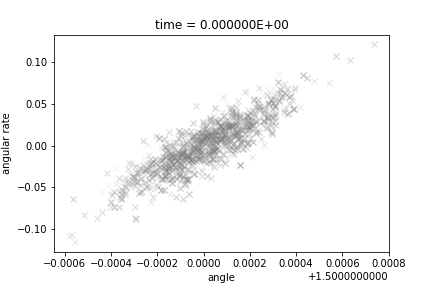

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
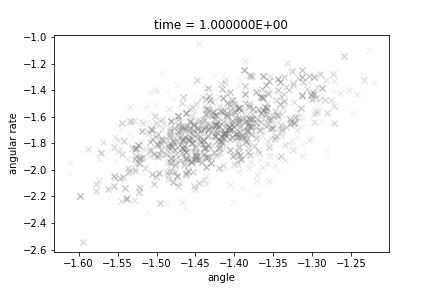

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
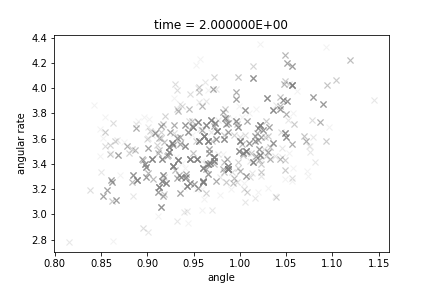

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
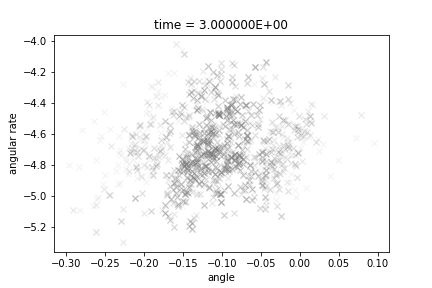

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
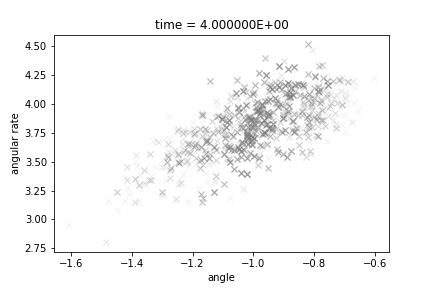

In [23]:
# different timesteps joint kismi, at 5 equally spaced time instances

xlim = [-6, 6]
ylim = [-6, 6]
means = MEANPF
means, stds = compute_mean_std(samples, weights)
N, d = means.shape
for ii in range(N):
    if ii % 100 == 0:
#         print(ii, samples[ii].shape)
        fig, axs = plot_2d(weights[:, ii], samples[:, :, ii], xlim, ylim)
        axs.set_title("time = {:5E}".format(times[ii]))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

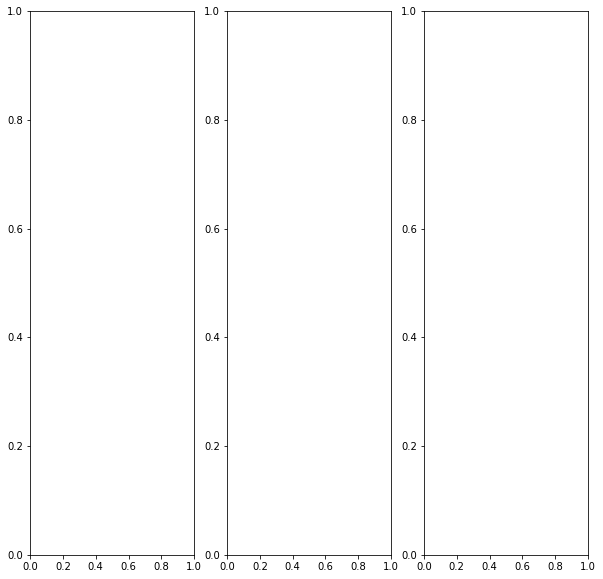

In [18]:
# jackin
x0 = np.array([1.5, 0])
Nsteps = 500
N = Nsteps
qc = 0.1
deltat = 0.01
dt = deltat
deltaArray = np.array([40,10,5])
RArray = np.array([1, 0.1, 0.01]) 
Q = np.array([[(qc*deltat**3)/3 , (qc*deltat**2)/2 ],
              [(qc*deltat**2)/2 ,  qc*deltat]])
proc_var = qc


# fig, sp = plt.subplots(1,2,figsize=(15,15))    
# fig2, sp2 = plt.subplots(1,2,figsize=(15,15)) 
# fig3, sp3 = plt.subplots(1,2,figsize=(15,15))
fig5, sp5 = plt.subplots(1,3,figsize=(10,10))

# fig5, sp5 = plt.subplots(2,3,figsize=(10,10))


for i in range(3):
    delta = deltaArray[i]
    R = RArray[i]
    
#     MEANPF = np.zeros((Nsteps, 2))
#     STDPF = np.zeros((Nsteps, 2))
    
    true = np.zeros((Nsteps, 2))
    true[0, :] = x0
    times = np.arange(0, Nsteps*dt, dt)
    data = np.zeros((Nsteps-1, 1))

    
#     data = np.zeros((int(np.ceil(Nsteps/delta))-1, 1))
#     print(data.shape)
    ns = R # 1.0 # standard deviation of noise
    noise_var = ns*ns
    
    proc_mat = Q
    proc_mat_inv = np.linalg.pinv(proc_mat)
    Lproc  = np.linalg.cholesky(proc_mat)

     
       

    for ii in range(1, Nsteps):
        true[ii, :] = pendulum_dyn(true[ii-1, :],dt=dt)
        data[ii-1] = observe(true[ii, :]) + np.random.randn()*R
   
    T = N*deltat
    ty = np.linspace(0, T, int(np.ceil((N/delta))))
# print(ty.shape)  
# print(data.shape)



#     fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#     axs[0].plot(times, true[:, 0])
#     axs[0].plot(ty[1:], data[1:], 'ko', ms=3)
#     axs[0].set_xlabel("Time", fontsize=14)
#     axs[0].set_ylabel("Position", fontsize=14)
#     axs[1].plot(times, true[:, 1])
#     axs[1].set_xlabel("Time", fontsize=14)
#     axs[1].set_ylabel("Velocity", fontsize=14)
#     plt.show()
    
    # PF
    prior_mean = true[0, :] # start at the truth -- this is obviously not possible in reality
    prior_cov = Q #np.eye(2) # identity covariance
#     print(data.shape)
    samples, weights, eff =  particle_filter(data, prior_mean, prior_cov,              
                                            proposal, proposal_logpdf, likelihood, proposal_logpdf,delta,R,
                                            nsamples=1000, resampling_threshold_frac=0.1)
    

#     print(samples.shape)
#     print(weights.shape)
#     print(mean.shape)
#     MEANPF[ii,:]=meanPF
#     STDPF[ii,:]= stdPF
   
#     MEANPF[ii,:]=np.dot(weights[:,ii],samples[:,:,ii])
#     STDPF[ii,:]= np.sqrt(np.dot(weights[:, ii], (samples[:, :, ii] - np.tile(MEANPF[ii, :], (N, 1)))**2))
    
    
    
    MEANPF, STDPF= compute_mean_std(samples, weights)
    MEANPF = MEANPF.T
#     print(samples.shape)
#     print(MEANPF.shape)
#     print(times.shape)
#     print(true.shape)
    j=0
    sp5[j,i].plot(times, true[:, 0],'--', color='purple', label='True Angle')
    sp5[j,i].plot(times, true[:, 1],'--', color='pink', label='True Angular Rate')
    
#     for ii in range(1, Nsteps):
#     if (ii-1)%delta == 0 and (ii-1) != 0:
    ty = np.linspace(0, T, int(np.ceil((N/delta))))
    sp5[j,i].plot(ty, data[::delta], 'co', alpha=0.5, label='Angle Measurements')


#     sp5[j,i].plot(ty[1:], data, 'co', alpha=0.5, label='Angle Measurements')
    sp5[j,i].plot(times, MEANPF[0,:], color='purple', label='PF Angle Estimate')
    sp5[j,i].plot(times, MEANPF[1,:], color='pink', label='PF Angular Rate Estimate')
    sp5[j,i].fill_between(times, MEANPF[0,:] - 2 * STDPF[:, 0],  MEANPF[0,:] + 2*STDPF[:, 0],
                color='purple', alpha=0.3) 
    sp5[j,i].fill_between(times, MEANPF[1,:] - 2 * STDPF[:, 1],  MEANPF[1,:] + 2*STDPF[:, 1],
                color='pink', alpha=0.3)
    
    #UKF
    
#     meanpost, covpost = UKF(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, delta)
#     std_devs = get_std(covpost) #extract the standard deviations at all the states
#     j=1
#     sp5[j,i].plot(t, true[:, 0],'--', color='purple', label='True Angle')
#     sp5[j,i].plot(t, true[:, 1],'--', color='pink', label='True Angular Rate')
#     sp5[j,i].plot(ty, data, 'co', alpha=0.5, label='Angle Measurements')
#     sp5[j,i].plot(t, meanpost[0,:], color='purple', label='UKF Angle Estimate')
#     sp5[j,i].plot(t, meanpost[1,:], color='pink', label='UKF Angular Rate Estimate')
#     sp5[j,i].fill_between(t, meanPF[0,:] - 2 * stdPF[:, 0],  meanPF[0,:] + 2*stdPF[:, 0],
#                 color='purple', alpha=0.3) 
#     sp5[j,i].fill_between(t, meanPF[1,:] - 2 * stdPF[:, 1],  meanPF[1,:] + 2*stdPF[:, 1],
#                 color='pink', alpha=0.3)
 
   
    
    if i == 0:
        sp5[j,i].set_ylabel('R = ' +str(R),fontsize=10)
    if j == (np.size(deltaArray)-1) :
        sp5[j,i].set_xlabel('Time', fontsize=10)
    if j == 0:
        sp5[j,i].set_title('$\delta$ = ' +str(delta)) 


sp5[j,i].legend(bbox_to_anchor=(1,0), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=1) 


In [15]:
data[::20]

array([[ 1.00454373],
       [ 0.94602407],
       [ 0.65892344],
       [-0.11569123],
       [-0.8034499 ],
       [-0.97990538],
       [-1.0014318 ],
       [-0.98497673],
       [-0.62489522],
       [ 0.16504682],
       [ 0.83536588],
       [ 0.99109573],
       [ 1.00765921],
       [ 1.00326156],
       [ 0.67713192],
       [-0.13263988],
       [-0.83461019],
       [-1.00593937],
       [-0.98608115],
       [-0.99013728],
       [-0.79988242],
       [-0.01044878],
       [ 0.78779092],
       [ 0.99767873],
       [ 0.95414887]])

In [ ]:
# deltavect = np.array([5,10,20,40])
# Rvect = np.array([1,0.1,0.01,0.001])


deltaArray = np.array([40,10,5])
RArray = np.array([1, 0.1, 0.01]) 



def plot_particle_filter(RArray,deltaArray):
   
    T = 5
    x0k = np.array([[1.5],[0]])
    dt = 0.01
    qc = 0.1
    delta = 5 # time discretization error, only use a model that integrates at 5 times larger time step (and observes more rarely)
    Nsims_sim = int(T / dt)

    tsim = np.linspace(0, T, Nsims_sim)

    

    Q = np.array([[qc*(dt**3)/3, qc*(dt**2)/2],[qc*(dt**2)/2,qc*dt]])

    alpha = 1 
    beta = 0
    kappa = 0
   
    fig, axs = plt.subplots(len(deltavect), len(Rvect), figsize=(20,20))
    fig.tight_layout()

    for ii in range(len(deltavect)):
        for jj in range(len(Rvect)):
            
            delta = deltavect[ii]
            R = Rvect[jj]
            
            x0 = np.array([1.5, 0])
            dt = 0.01
            Nsteps = 500
            true = np.zeros((Nsteps, 2))
            true[0, :] = x0
            times = np.arange(0, Nsteps*dt, dt)
            data = np.zeros((Nsteps-1, 1))
            
            for kk in range(1, Nsteps):
                true[kk, :] = pendulum_dyn(true[kk-1, :],dt=dt)
                data[kk-1] = observe(true[kk, :]) + np.random.randn()*R
            
            prior_mean = true[0, :] # start at the truth -- this is obviously not possible in reality
            prior_cov = np.eye(2) # identity covariance
            
            

            samples, weights, eff =  particle_filter(data, prior_mean, prior_cov,              
                                            proposal, proposal_logpdf, likelihood, proposal_logpdf,
                                            delta, R, nsamples=1000, resampling_threshold_frac=0.1)
            means, stds = compute_mean_std(samples, weights)
            
            axs[ii,jj].plot(times, true[:, 0],'-r', label='True')
            axs[ii,jj].plot(times, means[:,0], '-', label='Filtered Mean')
            axs[ii,jj].plot(times[1:], data[:, 0], 'ko', ms=1, label='Data')
            axs[ii,jj].fill_between(times, means[:, 0] - 2 * stds[:, 0], means[:, 0]+2*stds[:, 0], color='blue', alpha=0.1, label=r'$2\sigma$') 
            axs[ii,jj].set_xlabel('Time',fontsize=14)
            axs[ii,jj].set_ylabel('Position', fontsize=14)
            axs[ii,jj].legend(fontsize=14)

    plt.show()

plot_particle_filter(Rvect,deltavect)